## Example: How to use a Jupyter notebook and the IAPWS steam table to analyze the performance of a thermoelectric power plant
Sometimes, you will need to install a module. In this example, we need a module in order to calculate thermodynamic properties. This module is called "iapws". 

To install a module, you type, where you replace the text "package-name" with the name of your module.  

!pip install package-name

So ours looks like:

In [1]:
!pip install iapws

In my case, it says that the requirement is already satisfied, perhaps because I installed it before. 

Next, we would like to calculate a thermodynamic property of steam. To do so, we need to import the module from iapws that is for water (IAPWS97). 

IAPWS stands for "The International Association for the Properties of Water and Steam". According to them, they are "...an international non-profit association of national organizations concerned with the properties of water and steam, particularly thermophysical properties, cycle chemistry guidelines, and other aspects of high-temperature steam, water and aqueous mixtures relevant to thermal power cycles and other industrial and scientific applications."

This looks like:

In [2]:
from iapws import IAPWS97

In order to calculate a thermodynamic property, we need to define several properties, such as temperature $T$ and pressure $P$, and for vapor-liquid mixtures, the quality $x$. $T$ should be in the units Kelvin, $P$ should be in MPa, and $x$ should be between 0 and 1.

So for saturated liquid water, $T_1 = 100 ^{\circ}$C, which we can convert to K by:

In [3]:
T1 = 100 + 273.15

As the liquid water is saturated, we then know that $x = 0$. Therefore,

In [5]:
quality = 0

We then have enough information to calculate all of the thermodynamic properties at this state. The first step in determining properties like $P$, specific entropy $s$, specific enthalpy $h$, etc., is to use the IAPWS97 module. This is written in this case as:

In [6]:
sat_liquid1 = IAPWS97(T=T1, x=quality)

From this, we can now calculate $P_1$ (MPa), $s_1$ (kJ/(kg K)), $h_1$ (kJ/kg), specific volume $v_1$ (m$^3$/kg).

In [7]:
P1 = sat_liquid1.P # MPa
s1 = sat_liquid1.s # kJ/kg*K
h1 = sat_liquid1.h # kJ/kg
v1 = sat_liquid1.v # m3/kg

If we want to analyze a steam cycle, we can define three other states. Here we will look at a Rankine cycle, an idealized cycle for a thermoelectric powerplant. So we can say that state 2 is after the compressor, so the pressure is higher ($P_2 = 3$ MPa), and we will assume that the compressor is isentropic ($s_1 = s_2$):

In [8]:
P2 = 3             # MPa
s2 = s1            # kJ/kg*K

Again, we can calculate the properties at this state as:

In [9]:
sat_liquid2 = IAPWS97(P=P2, s=s1)
T2 = sat_liquid2.T # K
h2 = sat_liquid2.h # kJ/kg

With the values of $P_1$, $P_2$, and $v_1$ known, we can calculate the specific work, $w_{12}$ (kJ/kg) done by this compressor as:

In [13]:
w12 = v1*(P2 - P1)*1e6/1e3 # kJ/kg; Pressure is in MPa units, and we want this to be in kJ/kg, hence the 1e6/1e3 ratio.

Note: 1e6 = 1000000 and 1e3 = 1000

We can print this value as:

In [14]:
print('The compressor work is: {0:1.4f} kJ/kg'.format(w12))

The compressor work is: 3.0245 kJ/kg


We can now define state 3 of our Rankine cycle, which is after the boiler. Let's assume that temperature is $T_3 = 600 ^{\circ}$C and that $P_3 = P_2$. 

In [15]:
T3 = 600 + 273.15 # K
P3 = P2 # definition of isobaric, MPa

Again, we can calculate the properties at this state as:

In [16]:
steam = IAPWS97(P=P3, T=T3)
h3 = steam.h # kJ/kg
s3 = steam.s # kJ/kg*K

We can calculate the heat transferred to the water $Q_\text{b}$ (kJ/kg), generating steam by taking the difference in specific enthalpy between states 3 and 2:

In [17]:
Qb = h3 - h2 # heat required to make the steam, kJ/kg

print('The boiler heat duty is: {0:1.2f} kJ/kg'.format(Qb))

The boiler heat duty is: 3260.69 kJ/kg


Next, the high pressure steam passes through the turbine, which is used to generate electricity in a powerplant. Here we assume that the turbine operates isentropically, $s_4 = s_3$, and that the pressure is the same as that at state 1, $P_4 = P_1$. 

With these assumptions, we can calculate the thermodynamic properties of state 4 as:

In [18]:
s4 = s3 # isentropic #kJ/kg*K

In [19]:
P4 = P1 # MPa

In [20]:
steam = IAPWS97(P=P4, s=s4)
T4 = steam.T # K
h4 = steam.h # kJ/kg

We can then calculate the specific work generated by the turbine, $w_{34}$:

In [23]:
w34 = h4 - h3 # work extracted from the expansion, kJ/kg
print('The turbine work is: {0:1.2f} kJ/kg'.format(w34))

The turbine work is: -946.71 kJ/kg


Next, the steam enters the condenser where it is cooled, condensing back into a liquid, where is it is then pumped by the compressor back into the boiler. The amount of heat removed by the condenser can be calculated as ($Q_{\text{c}}$):

In [22]:
Qc = h4 - h1 # Cooling from T4 to T1, kJ/kg
print('The condenser heat duty is {0:1.2f} kJ/kg'.format(Qc))

The condenser heat duty is 2317.00 kJ/kg


The efficiency of the Rankine cycle can be calculated then as:

In [24]:
eta = -(w34 - w12) / Qb

print('The overall efficiency is {0:1.2%}.'.format(eta))

The overall efficiency is 29.13%.


The negative sign we have in front of the $w_{34}$ is due to the convention we used here. In our convention, the work we calculated was the energy consumed by the device. Normally, the convention in thermodynamics is that the work done by a system is positive, and the heat transferred into a system is positive. The opposites of this are then negative. For whatever convention you decide to use, the main point is to be consistent, although we recommend following the norm. 

We can now show this Rankine cycle on the T-s diagram, as is customary. We can also save this plot as an image. For this we need to import some additional modules. 

In [25]:
import numpy as np
import matplotlib.pyplot as plt

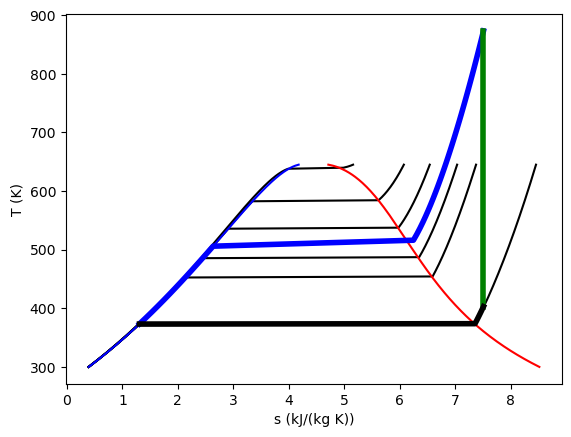

In [28]:
plt.figure()
plt.clf()
T = np.linspace(300, 372+273, 200) # range of temperatures
for P in [0.1, 1, 2, 5, 10, 20]: #MPa
    steam = [IAPWS97(T=t, P=P) for t in T]
    S = [s.s for s in steam]
    plt.plot(S, T, 'k-')

# saturated vapor and liquid entropy lines
svap = [s.s for s in [IAPWS97(T=t, x=1) for t in T]]
sliq = [s.s for s in [IAPWS97(T=t, x=0) for t in T]]

plt.plot(svap, T, 'r-')
plt.plot(sliq, T, 'b-')

plt.xlabel('s (kJ/(kg K))')
plt.ylabel('T (K)')
plt.savefig('iawps-steam.png')

T23 = np.linspace(T2, T3)
S23 = [s.s for s in [IAPWS97(P=P2, T=t) for t in T23]]

T41 = np.linspace(T4, T1 - 0.01) # subtract a tiny bit to make sure we get a liquid
S41 = [s.s for s in [IAPWS97(P=P1, T=t) for t in T41]]

plt.plot([s1, s2], [T1, T2], 'r-', lw=4) # Path 1 to 2
plt.plot(S23, T23, 'b-', lw=4) # path from 2 to 3 is isobaric
plt.plot([s3, s4], [T3, T4], 'g-', lw=4) # path from 3 to 4 is isentropic
plt.plot(S41, T41, 'k-', lw=4) # and from 4 to 1 is isobaric